<a href="https://colab.research.google.com/github/Muradrassam2024/Murad/blob/main/Final_Anomaly_Detection_Using_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

## Load the data

In [2]:
from google.colab import files
uploaded=files.upload()

Saving subj330ready.csv to subj330ready.csv


In [3]:
data=pd.read_csv('subj330ready.csv', header=None)
print(data.shape)
data.head()

(14287, 7)


,0,1,2,3,4,5,6
0,95.8,151.5,94.1,115.2,95.5,96.1,0
1,91.9,148.4,91.4,112.1,91.9,95.1,0
2,92.4,149.7,94.1,114.4,93.0,96.2,0
3,107.8,149.7,95.8,115.7,107.0,96.8,0
4,101.6,153.2,96.0,117.2,99.0,96.8,0


## Split the data for training and testing

In [4]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = 6

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target)


In [5]:
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

## Scale the data using MinMaxScaler

In [6]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

## Build an AutoEncoder model

In [7]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units

  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0240 - mse: 0.0560 - val_loss: 0.0234 - val_mse: 0.0717
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0125 - mse: 0.0280 - val_loss: 0.0151 - val_mse: 0.0532
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0071 - mse: 0.0163 - val_loss: 0.0064 - val_mse: 0.0276
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0035 - mse: 0.0078 - val_loss: 0.0052 - val_mse: 0.0237
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0029 - mse: 0.0063 - val_loss: 0.0044 - val_mse: 0.0214
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0021 - mse: 0.0046 - val_loss: 0.0038 - val_mse: 0.0200
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0015 - mse: 0.0034 - val_loss: 0.0030 - val_mse: 0.0183
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.0528e-04 - mse: 0.0022 - val_loss: 0.0026 - val_mse: 0.0175
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 7

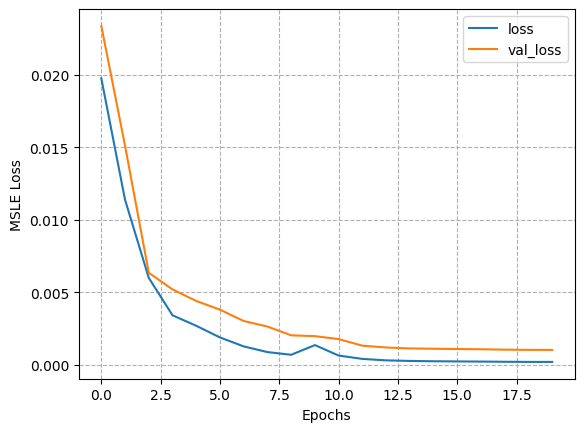

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Threshold method one: 0.0006922846387692395
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.946133796698523
Recall: 0.9569420035149385
F1 Score: 0.9515072083879423


In [8]:
#Implementation-512
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)
#Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.grid(linestyle="--")

plt.legend(['loss', 'val_loss'])
plt.show()

#Find threshold
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds
  return predictions
  #return errors

#Calculate the threshold
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

#threshold_2 = find_threshold_method_two(model, x_train_scaled)
#print(f"Threshold method two: {threshold_2}")

#Calculate accuracy
preds1 = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds1, y_test)

#Calculate Preciosn,recall, and F1-score
# Assuming 'true_labels' is a binary array indicating true anomalies (1) and normal instances (0)
# Adjust this array based on your labeled data
true_labels=target[x_test.index]

# Use the 'anomalies' array from the previous code as predicted labels
# Adjust this array based on the anomalies predicted by your autoencoder model
predicted_labels = preds1

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



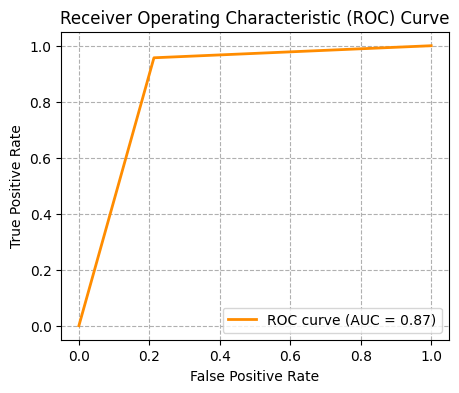

In [9]:
#Plot ROC/AUC
# Assuming 'predictions' are the output of your autoencoder and 'true_labels' are the actual labels
fpr, tpr, _ = roc_curve(true_labels, preds1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.grid(linestyle="--")
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0198 - mse: 0.0457 - val_loss: 0.0083 - val_mse: 0.0321
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042 - mse: 0.0091 - val_loss: 0.0044 - val_mse: 0.0221
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0022 - mse: 0.0047 - val_loss: 0.0030 - val_mse: 0.0185
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0011 - mse: 0.0026 - val_loss: 0.0018 - val_mse: 0.0153
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.4151e-04 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0138
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.6663e-04 - mse: 8.8741e-04 - val_loss: 0.0011 - val_mse: 0.0135
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.9239e-04 - mse: 7.0567e-04 - val_loss: 0.0011 - val_mse: 0.0133
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 2.5514e-04 - mse: 6.0747e-04 - val_loss: 0.0010 - val_mse: 0.0130
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━

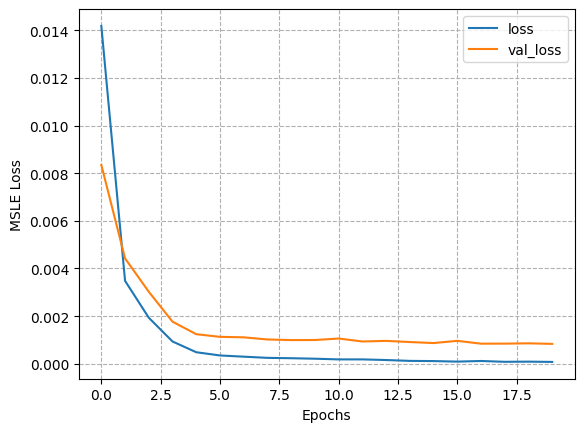

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Threshold method one: 0.0003223445914963348
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.9568407423392318
Recall: 0.9740773286467487
F1 Score: 0.9653821032005225


In [10]:
#Implementation-256
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=256,
    validation_data=(x_test_scaled, x_test_scaled)
)
#Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.grid(linestyle="--")

plt.legend(['loss', 'val_loss'])
plt.show()

#Find threshold
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds= anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds
  #return predictions
  #return errors

#Calculate the threshold
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

#threshold_2 = find_threshold_method_two(model, x_train_scaled)
#print(f"Threshold method two: {threshold_2}")

#Calculate accuracy
preds2 = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds2, y_test)

#Calculate Preciosn,recall, and F1-score
# Assuming 'true_labels' is a binary array indicating true anomalies (1) and normal instances (0)
# Adjust this array based on your labeled data
true_labels=target[x_test.index]

# Use the 'anomalies' array from the previous code as predicted labels
# Adjust this array based on the anomalies predicted by your autoencoder model
predicted_labels = preds2

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



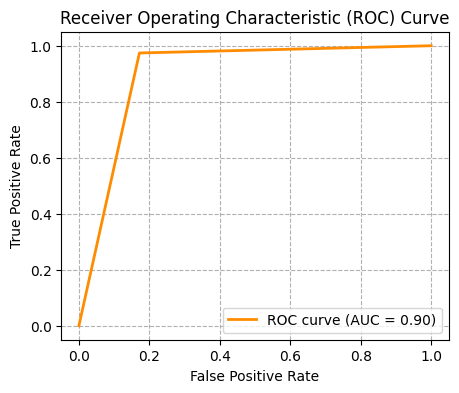

In [11]:
#Plot ROC/AUC
# Assuming 'predictions' are the output of your autoencoder and 'true_labels' are the actual labels
fpr, tpr, _ = roc_curve(true_labels, preds2)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.grid(linestyle="--")
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0154 - mse: 0.0351 - val_loss: 0.0048 - val_mse: 0.0224
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - mse: 0.0054 - val_loss: 0.0024 - val_mse: 0.0169
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.9757e-04 - mse: 0.0017 - val_loss: 0.0013 - val_mse: 0.0140
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.4352e-04 - mse: 8.4896e-04 - val_loss: 0.0011 - val_mse: 0.0133
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8776e-04 - mse: 6.9413e-04 - val_loss: 0.0011 - val_mse: 0.0131
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4275e-04 - mse: 5.7239e-04 - val_loss: 0.0010 - val_mse: 0.0131
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.0777e-04 - mse: 4.9146e-04 - val_loss: 9.4537e-04 - val_mse: 0.0128
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8661e-04 - mse: 4.3492e-04 - val_loss: 9.5110e-04 - val_mse: 0.0128
Epoch 9/20
7

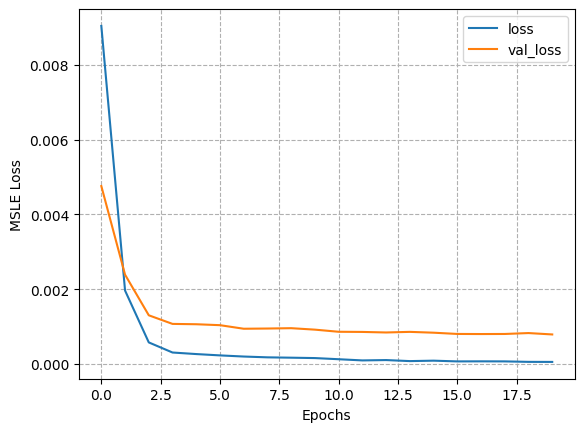

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Threshold method one: 0.00025448265241206024
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.961038961038961
Recall: 0.9753954305799648
F1 Score: 0.9681639773222852


In [12]:
#Implementation-128
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)
#Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.grid(linestyle="--")

plt.legend(['loss', 'val_loss'])
plt.show()

#Find threshold
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds
  #return predictions
  #return errors

#Calculate the threshold
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

#threshold_2 = find_threshold_method_two(model, x_train_scaled)
#print(f"Threshold method two: {threshold_2}")

#Calculate accuracy
preds3 = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds3, y_test)

#Calculate Preciosn,recall, and F1-score
# Assuming 'true_labels' is a binary array indicating true anomalies (1) and normal instances (0)
# Adjust this array based on your labeled data
true_labels=target[x_test.index]

# Use the 'anomalies' array from the previous code as predicted labels
# Adjust this array based on the anomalies predicted by your autoencoder model
predicted_labels = preds3

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



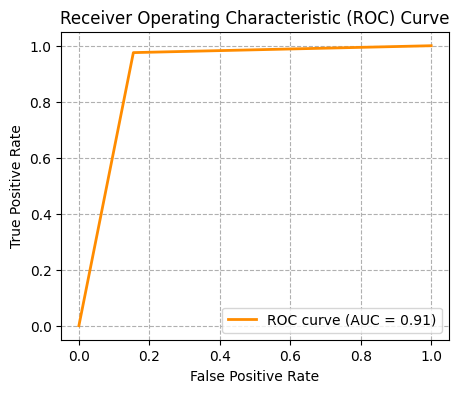

In [13]:
#Plot ROC/AUC
# Assuming 'predictions' are the output of your autoencoder and 'true_labels' are the actual labels
fpr, tpr, _ = roc_curve(true_labels, preds3)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.grid(linestyle="--")
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0121 - mse: 0.0274 - val_loss: 0.0041 - val_mse: 0.0211
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0017 - mse: 0.0037 - val_loss: 0.0013 - val_mse: 0.0138
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.2182e-04 - mse: 7.6648e-04 - val_loss: 0.0011 - val_mse: 0.0132
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.3203e-04 - mse: 5.3467e-04 - val_loss: 0.0010 - val_mse: 0.0129
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1348e-04 - mse: 4.8126e-04 - val_loss: 0.0010 - val_mse: 0.0130
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.5338e-04 - mse: 3.5208e-04 - val_loss: 9.1792e-04 - val_mse: 0.0127
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2001e-04 - mse: 2.7539e-04 - val_loss: 0.0010 - val_mse: 0.0130
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2460e-04 - mse: 2.8372e-04 - val_loss: 8.6738e-04 - val_mse:

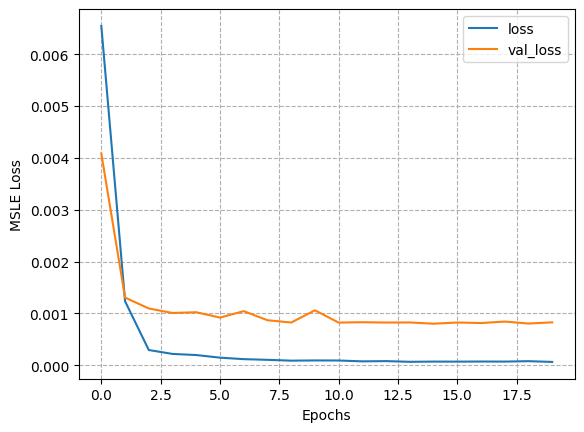

285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Threshold method one: 0.000303099018438902
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precision: 0.9428208386277002
Recall: 0.9780316344463972
F1 Score: 0.9601035152037956


In [14]:
#Implementation-64
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=64,
    validation_data=(x_test_scaled, x_test_scaled)
)
#Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.grid(linestyle="--")

plt.legend(['loss', 'val_loss'])
plt.show()

#Find threshold
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds
  #return predictions
  #return errors

#Calculate the threshold
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

#threshold_2 = find_threshold_method_two(model, x_train_scaled)
#print(f"Threshold method two: {threshold_2}")

#Calculate accuracy
preds4 = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds4, y_test)

#Calculate Preciosn,recall, and F1-score
# Assuming 'true_labels' is a binary array indicating true anomalies (1) and normal instances (0)
# Adjust this array based on your labeled data
true_labels=target[x_test.index]

# Use the 'anomalies' array from the previous code as predicted labels
# Adjust this array based on the anomalies predicted by your autoencoder model
predicted_labels = preds4

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



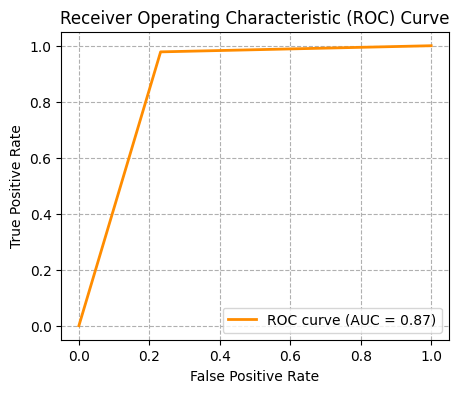

In [15]:
#Plot ROC/AUC
# Assuming 'predictions' are the output of your autoencoder and 'true_labels' are the actual labels
fpr, tpr, _ = roc_curve(true_labels, preds4)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.grid(linestyle="--")
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0095 - mse: 0.0215 - val_loss: 0.0019 - val_mse: 0.0155
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.2915e-04 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0135
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 2.4671e-04 - mse: 5.8434e-04 - val_loss: 0.0010 - val_mse: 0.0131
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.1219e-04 - mse: 4.9137e-04 - val_loss: 9.6383e-04 - val_mse: 0.0129
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1.5633e-04 - mse: 3.5794e-04 - val_loss: 8.9538e-04 - val_mse: 0.0127
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.1961e-04 - mse: 2.7650e-04 - val_loss: 9.2716e-04 - val_mse: 0.0127
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.0691e-04 - mse: 2.3985e-04 - val_loss: 8.5814e-04 - val_mse: 0.0125
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 8.7005e-05 - mse: 1.9344e-04 - val_loss: 8.4995e-

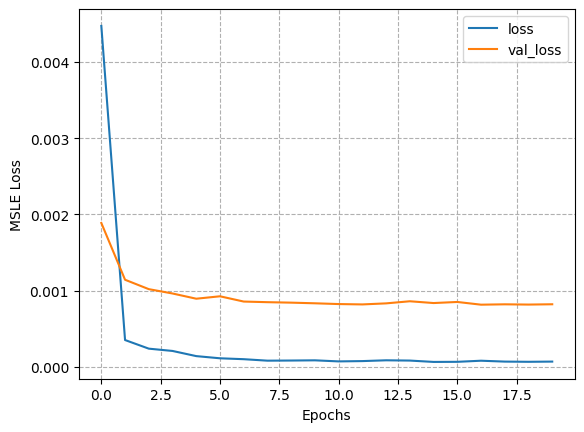

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Threshold method one: 0.0002948140556827966
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.9439252336448598
Recall: 0.976274165202109
F1 Score: 0.9598272138228942


In [16]:
#Implementation-32
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=32,
    validation_data=(x_test_scaled, x_test_scaled)
)
#Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.grid(linestyle="--")

plt.legend(['loss', 'val_loss'])
plt.show()

#Find threshold
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds
  #return predictions
  #return errors

#Calculate the threshold
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

#threshold_2 = find_threshold_method_two(model, x_train_scaled)
#print(f"Threshold method two: {threshold_2}")

#Calculate accuracy
preds5 = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds5, y_test)

#Calculate Preciosn,recall, and F1-score
# Assuming 'true_labels' is a binary array indicating true anomalies (1) and normal instances (0)
# Adjust this array based on your labeled data
true_labels=target[x_test.index]

# Use the 'anomalies' array from the previous code as predicted labels
# Adjust this array based on the anomalies predicted by your autoencoder model
predicted_labels = preds5

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



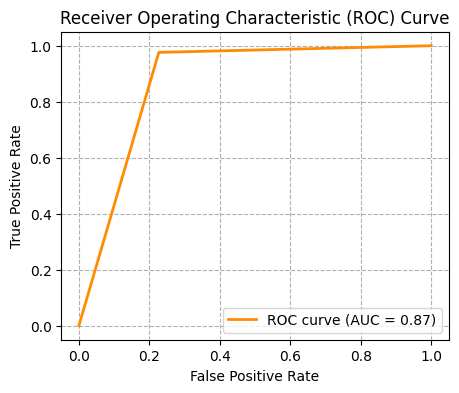

In [17]:
#Plot ROC/AUC
# Assuming 'predictions' are the output of your autoencoder and 'true_labels' are the actual labels
fpr, tpr, _ = roc_curve(true_labels, preds5)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.grid(linestyle="--")
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Epoch 1/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0068 - mse: 0.0152 - val_loss: 0.0023 - val_mse: 0.0162
Epoch 2/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 8.9779e-04 - mse: 0.0021 - val_loss: 0.0020 - val_mse: 0.0155
Epoch 3/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 8.1809e-04 - mse: 0.0020 - val_loss: 0.0019 - val_mse: 0.0152
Epoch 4/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 7.3113e-04 - mse: 0.0018 - val_loss: 0.0021 - val_mse: 0.0157
Epoch 5/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 6.8146e-04 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0151
Epoch 6/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 6.7118e-04 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0154
Epoch 7/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 6.4408e-04 - mse: 0.0016 - val_loss: 0.0021 - val_mse: 0.0157
Epoch 8/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 6.5302e-04 - mse: 0.0016 - val_loss: 0.0020 - val_mse: 0.0155
Epoch 9/20
569/569 ━━━━

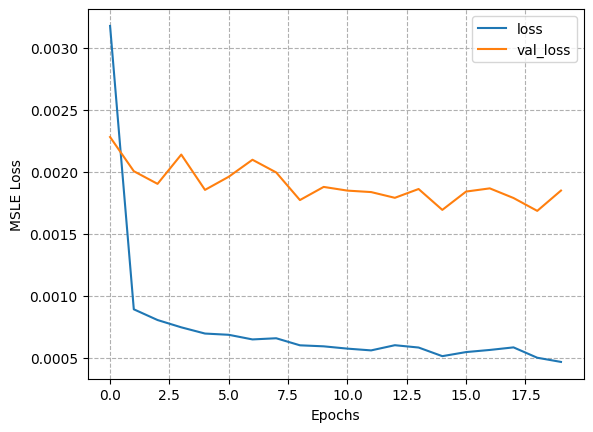

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Threshold method one: 0.0015054616868784517
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precision: 0.9313855688357681
Recall: 0.9244288224956063
F1 Score: 0.9278941565600882


In [18]:
#Implementation-16
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=16,
    validation_data=(x_test_scaled, x_test_scaled)
)
#Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.grid(linestyle="--")

plt.legend(['loss', 'val_loss'])
plt.show()

#Find threshold
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds
  #return predictions
  #return errors

#Calculate the threshold
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

#threshold_2 = find_threshold_method_two(model, x_train_scaled)
#print(f"Threshold method two: {threshold_2}")

#Calculate accuracy
preds6 = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds6, y_test)

#Calculate Preciosn,recall, and F1-score
# Assuming 'true_labels' is a binary array indicating true anomalies (1) and normal instances (0)
# Adjust this array based on your labeled data
true_labels=target[x_test.index]

# Use the 'anomalies' array from the previous code as predicted labels
# Adjust this array based on the anomalies predicted by your autoencoder model
predicted_labels = preds6

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



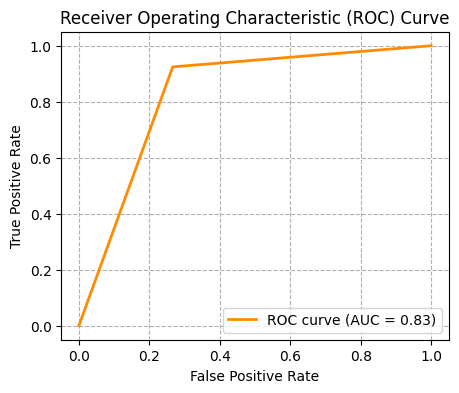

In [19]:
#Plot ROC/AUC
# Assuming 'predictions' are the output of your autoencoder and 'true_labels' are the actual labels
fpr, tpr, _ = roc_curve(true_labels, preds6)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.grid(linestyle="--")
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

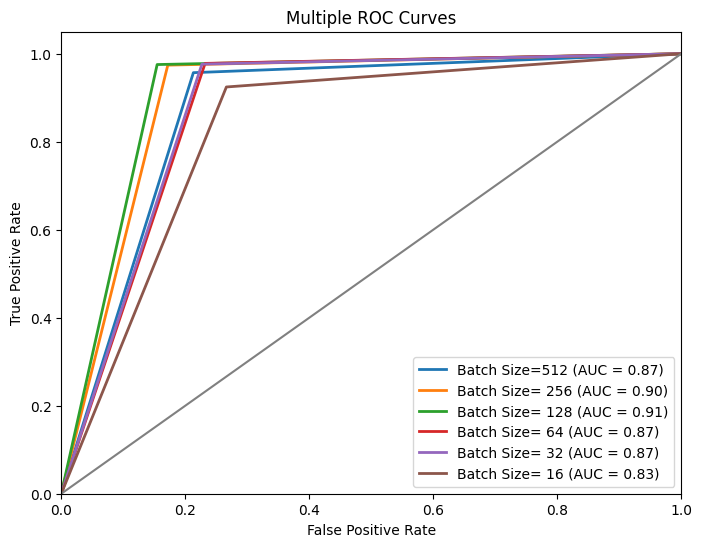

In [20]:
    plt.figure(figsize=(8, 6))
    anomaly_scores_list = [preds1, preds2, preds3, preds4,preds5,preds6]
    true_labels = [true_labels, true_labels, true_labels,true_labels,true_labels,true_labels]
    labels = ['Batch Size=512', 'Batch Size= 256', 'Batch Size= 128','Batch Size= 64', 'Batch Size= 32', 'Batch Size= 16']
    for true_labels, anomaly_scores, label in zip(true_labels, anomaly_scores_list, labels):
        fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='-')  # Diagonal line for random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiple ROC Curves')
    plt.legend(loc="lower right")
    plt.show()



## Plot history